# Preprocessing the original dataset  
This file contains code to preprocess the original dataset and augment the data by generating new image files derived from the original dataset and saving them into a new location.  
After several iterations the solution that works best is using only shifting techniques to shift images to the left and right and correcting the steering accordingly.  
All images were cropped in order to eliminate useless information (car and sky) and decrease the image size which contributes to speed up the training process.  

In [2]:
import pandas as pd
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
import math

from keras.models import Sequential
from keras.layers import Dense, Activation
import cv2

import json
import random

Using TensorFlow backend.


In [33]:
# Load the data by reading the logfile

data = pd.read_csv('data/data/driving_log.csv',dtype={'center': str, 'left':str,'right':str,
                                                      'steering': np.float32,'throttle': np.float32,
                                                      'brake': np.float32,'speed': np.float32},
                   skipinitialspace=1)
                   #converters={'category',"Price":int} dtype='category')
print(data.dtypes)

X_train = data['center']
y_train = data['steering']

center = data['center']
left = data['left']
right = data['right']
steering = data['steering']
throttle = data['throttle']
speed=data['speed']
brake=data['brake']
print('Training data size = ', len(X_train))
print('Training labels size = ',len(y_train))
print('Training throttle size = ',len(throttle))
print('Training speed size = ',len(speed))

print('Data loaded')

center       object
left         object
right        object
steering    float32
throttle    float32
brake       float32
speed       float32
dtype: object
Training data size =  8036
Training labels size =  8036
Training throttle size =  8036
Training speed size =  8036
Data loaded


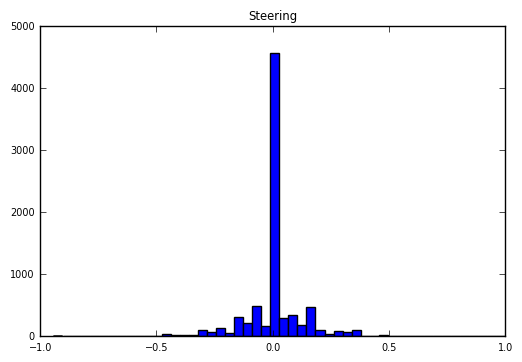

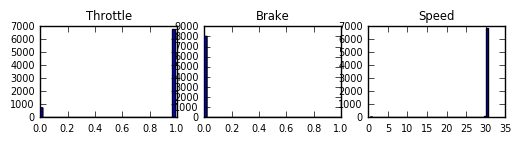

In [38]:
# examine the data
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 7})
fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)
ax1.set_title('Steering')
plt.hist(steering,50);

fig = plt.figure()
ax1 = fig.add_subplot(3,3,1)
ax1.set_title('Throttle')
plt.hist(throttle,50);
ax2 = fig.add_subplot(3,3,2)
ax2.set_title('Brake')
plt.hist(brake,50);
ax3 = fig.add_subplot(3,3,3)
ax3.set_title('Speed')
plt.hist(speed,50);
plt.show()

# Notes: 
Steering values range from -1 to 1 but there is a huge spike near zero.  
Throttle values seem to be either almost 1 either 0.  
Brake values range from 0 to 1, being zero most of the times.  
Speed values range from 0 to 35 being most predominantly around 30.  

In [15]:
import numpy as np

def rotate_image(image, angle):
    radians = angle*math.pi/180
    (height, width, channels) = image.shape
    rot_mat = cv2.getRotationMatrix2D((width/2,height/2),angle,1.0)
    return cv2.warpAffine(image, rot_mat, (width, height),flags=cv2.INTER_LINEAR),radians

# amount: negative values shift to the left, positive values shift to the right
def shift_and_crop (filename,steering,amount):
    img = cv2.imread(filename)
    (rows,cols,channels) = img.shape
    M = np.float32([[1,0,amount],[0,1,0]])
    dst = cv2.warpAffine(img,M,(cols,rows))
    crop_img = crop_image(dst)
    steering = steering+amount/100.0
    
    return crop_img, steering

def crop_image(dst): 
    crop_img = dst[60:140, 10:310] # original size 320 x 160, final size 300 x 80crop_img
    return crop_img

print('crop_images function defined')

crop_images function defined


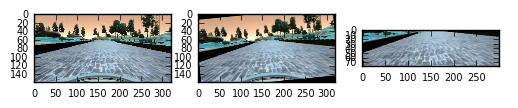

Image size: (160, 320, 3)


In [39]:
# test rotate image
img = cv2.imread('./data/data/'+X_train[0])

# original image
fig = plt.figure()
ax1 = fig.add_subplot(1,3,1)
plt.imshow(img)

# rotated image
img_rot,img_st = rotate_image(img,0.1*180/math.pi)
ax2 = fig.add_subplot(1,3,2)
plt.imshow(img_rot)
ax2 = fig.add_subplot(1,3,3)

# cropped image
crop_img = crop_image(img_rot)
plt.imshow(crop_img)
plt.show()

print('Image size:',img.shape)

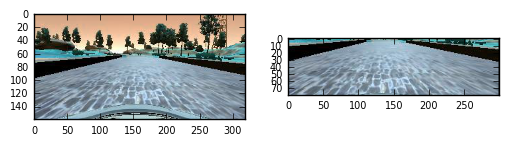

Original Steering: 0.0
Final Steering: -0.12


In [30]:
# test shifting image
img = cv2.imread('./data/data/'+X_train[0])

filename = './data/data/'+X_train[0]
steering = y_train[0]
amount = -12

# original image
fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
plt.imshow(img)

# shifted and cropped image
img_crop,ster = shift_and_crop (filename,steering,amount)
#ax2 = fig.add_subplot(1,2,2)
plt.imshow(img_crop)
plt.show()

print('Original Steering:',steering)
print('Final Steering:',ster)

In [188]:
# Augment data by:
# 1) using only center camera 
#     a) crop images to relevant section (remove car and sky) 
# 2) shift images to left and right 
# 3) duplicate and flip images (invert steering)
# 
# From all of above just save those which fall under the desired probability

import random
import sys

random.seed()
count = 0
offset = 0.1 #steering offset for left and right cameras
print('Saving augmented images. Please wait...')
logfile = open('./data/new_data/new_log.csv','a')
num_iter = len(center)

for i in range(num_iter):
    
    # discard data corresponding to:
    #  - very small steering values;
    #  - braking events;
    #  - very small speed;
    #  - no throttle applied.
    if abs(steering[i])<0.0001 or brake[i]>0 or speed[i]<5 or throttle[i]<0.5:
        continue

    new_images = []
    new_steering = []

    #center camera
    filename = 'data/data/'+center[i]
    img = cv2.imread(filename)
    
    #crop image to relevant section (remove car and sky)     
    crop_img = crop_image(img)
    new_images.append(crop_img)
    new_steering.append (steering[i])
    
    # create five new images shifted to left
    # and another five shifted to the right
    for k in range(5):
        new_img, new_st = shift_and_crop (filename,steering[i],-15+k*3)
        new_images.append(new_img)
        new_steering.append(new_st)
        
        new_img, new_st = shift_and_crop (filename,steering[i],15-k*3)
        new_images.append(new_img)
        new_steering.append(new_st)
    
    for j in range(len(new_images)):
        # add flipped images
        new_images.append(cv2.flip(new_images[j],1))
        new_steering.append((new_steering[j])*(-1))

    assert (len(new_images)==22)
    
    # save according to the probability
    # higher steering have higher probability of being saved
    for j in range(len(new_images)):
        rand_num = random.random()
        #print(rand_num,',',abs(new_steering[j]))
        if (abs(new_steering[j])+0.02)>=rand_num:
            #save this image to the final set    
            filename = 'IMG/image_'+str(count)+'.jpg'
            count = count+1
            cv2.imwrite('data/new_data/'+filename,new_images[j])
            logfile.write(filename+','+str(new_steering[j])+'\n')
                         
logfile.close()

print('Total images saved:',count)

Saving augmented images. Please wait...
Total images saved: 13626


In [31]:
# read new saved images

data = pd.read_csv('data/new_data/new_log.csv',
                   dtype={'center': str,'steering': np.float32},
                   skipinitialspace=1)
print(data.dtypes)

X_train = data['center']
y_train = data['steering']

print('Training data size = ', len(X_train))
print('Training labels size = ',len(y_train))

print('Data loaded')

center       object
steering    float32
dtype: object
Training data size =  11174
Training labels size =  11174
Data loaded


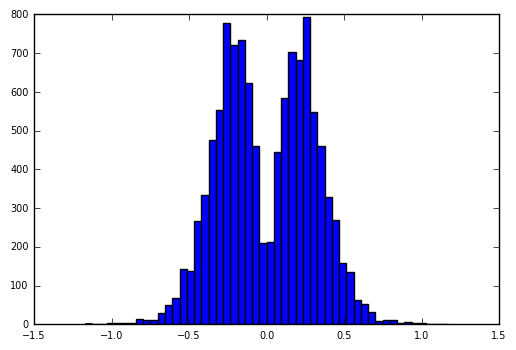

X_train: 11174
y_train: 11174


In [32]:
# examine the new dataset

import matplotlib.pyplot as plt
plt.hist(y_train,50)
plt.show()
data = list(X_train)
labels = list(y_train)
print('X_train:',len(X_train))
print('y_train:',len(y_train))

# Conclusion
The original dataset comprised 8036 color images with size 320x160.  
The final dataset comprised 11174 color images with size 300x80.  
The distribution of the samples is much broader in the new set compared to the original one which means that training will be much more effective.  
Also there some more images in the new dataset.  
The images in the new dataset are cropped meaning that useless features were eliminated and because the size is about half of the original one the training process will be much faster as well.  